In [22]:
from mongo import MongoDBManager
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt

# Retrieving data

In [ ]:
load_dotenv()
uri = os.getenv('MONGODB_URI')
database_name = os.getenv('DATABASE_NAME')
mongo_manager = MongoDBManager(uri, database_name)

In [51]:
documents = mongo_manager.read_all_documents_in_collection_with_GridFS()

# Formating Datas

In [53]:
data_formated = []
for country in documents.keys():
   for profession in documents[country].keys():
       for language in documents[country][profession].keys():
            for data in documents[country][profession][language]:
                data['country'] = country
                data['profession'] = profession
                data['language'] = language
                data_formated.append(data)
               
len(data_formated)

23993

# Visualizing Data

In [54]:
df = pd.DataFrame(data_formated)
df.describe()

,positionTitle,companyName,location,jobType,description,datePosted,salary,shiftAndSchedule,jobBenefits,country,profession,language
count,23993,23993,23993,23993,23993,22921,23993,23993,23993,23993,23993,23993
unique,6264,4197,2944,1165,6739,35,1547,114,1830,3,5,2
top,Financial Analyst,Scotiabank,"Toronto, ON",[Temps plein],Posting Information\n\nPosting Number\nPG19356...,2024-07-17,,,[],Canada,Analyste de marché,en
freq,258,277,1494,5017,72,4301,5229,21768,10878,13491,9673,19943


In [55]:
df = df.applymap(lambda x: tuple(x) if isinstance(x, list) else x)
df = df.drop_duplicates()
df.describe()

C:\Users\PC\AppData\Local\Temp\ipykernel_18972\661522275.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: tuple(x) if isinstance(x, list) else x)


,positionTitle,companyName,location,jobType,description,datePosted,salary,shiftAndSchedule,jobBenefits,country,profession,language
count,14112,14112,14112,14112,14112,13515,14112,14112,14112,14112,14112,14112
unique,6264,4197,2944,1165,6739,35,1547,114,1830,3,5,2
top,Financial Analyst,Scotiabank,"Toronto, ON","(Temps plein,)","Who we are\nFor over 50 years, we have worked ...",2024-07-20,,,(),Canada,Analyste de marché,en
freq,171,188,923,3247,42,2840,3833,12967,6563,8296,5782,11570


<Axes: xlabel='location'>

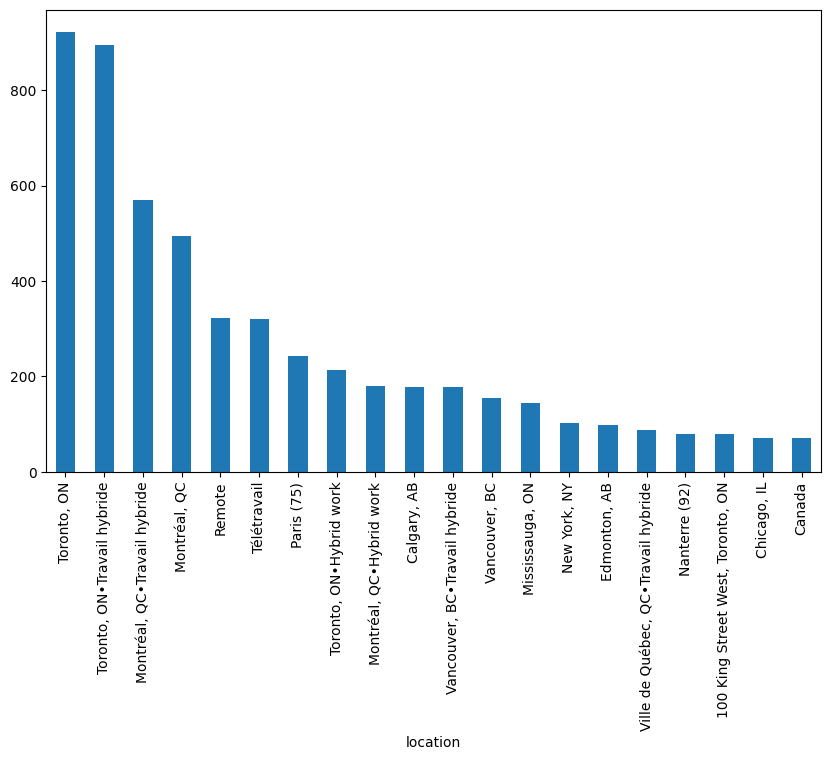

In [56]:
plt.figure(figsize=(10, 6))
df['location'].value_counts()[:20].plot(kind='bar')

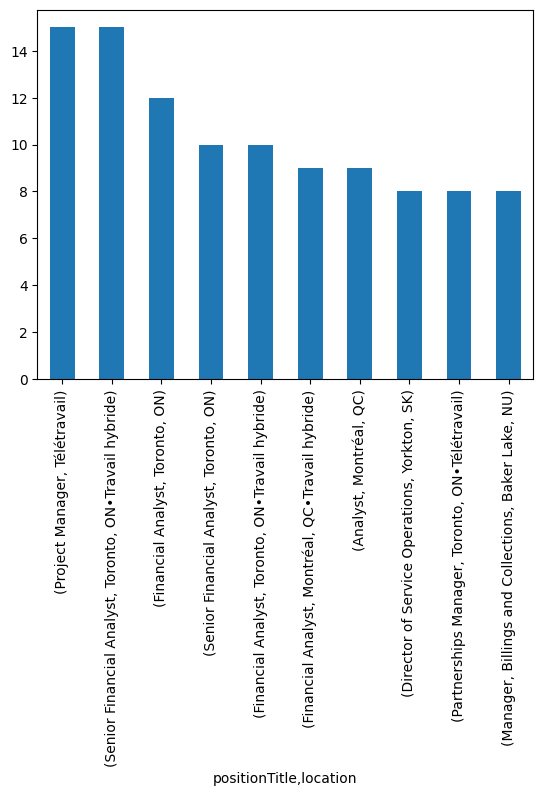

In [48]:
df_counts = df[['positionTitle','location']].value_counts()[:10].plot(kind='bar')
# df_counts.plot(kind='scatter', x='positionTitle', y='location', s=df_counts['count'] * 10)
# plt.xticks(rotation=45)
# plt.show()

<Axes: xlabel='positionTitle'>

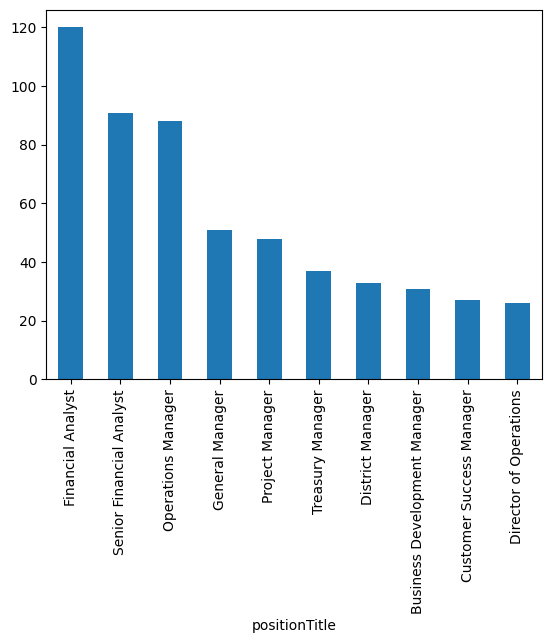

In [49]:
df['positionTitle'].value_counts()[:10].plot(kind='bar')